In [2]:
import tweepy as tw
import pandas as pd
import configparser as cp
from textblob import TextBlob
import re
import json
import numpy as np
import nltk
import sklearn 
import seaborn as sb
import matplotlib.pyplot as plt
from colorama import Fore,Style,Back
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
#ALGORITMOS SELECIONADOS ATÉ O MOMENTO
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
#-----------------------------------------
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## mudar thema do notebook jt -t solarizedd -T -N -kl
# Resetar thema jt -r

np.random.seed(1914)

In [2]:
# nltk.download()

In [3]:
# config = cp.ConfigParser()
# config.read('config.ini')
# api_key = config['twitter_credenciais']['api_key']
# api_key_secret = config['twitter_credenciais']['api_key_secret']
# access_token = config['twitter_credenciais']['access_token']
# access_token_secret = config['twitter_credenciais']['access_token_secret']

In [4]:
# auth = tw.OAuthHandler(api_key,api_key_secret)
# auth.set_access_token(access_token,access_token_secret)
# api = tw.API(auth)

In [3]:
df = pd.read_csv('dataset_depressao.csv')
filter = (df['id_tweet'] == 3696)
df.loc[filter,'psiquico'] = 0 

In [4]:
df.rename(columns = {'label':'target'}, inplace = True)

In [5]:
display(df)

,id_tweet,ds_tweet,fisiologico,psiquico,comportamental,target,validado_espec,dh_tweet
0,3696,dormi o dia inteiro tinha horas w meu desperta...,1,0,0,1,1,2019-10-09 02:32:41.000000
1,3885,já entendi que eu não sou importante tá bom,0,1,0,3,1,2019-10-12 12:15:04.000000
2,3888,chorando pq não sou importante pra ngm 👍🏿 http...,0,1,0,3,1,2019-10-11 23:56:04.000000
3,3889,Sinto sempre que nao sou importante para certa...,0,1,0,3,1,2019-10-12 14:43:38.000000
4,8369,Tô indo pra escola com a força do ódio,0,0,0,0,1,2019-10-11 12:10:22.000000
...,...,...,...,...,...,...,...,...
4045,10629,@LUCAztec como ousa,0,0,0,0,0,2019-11-01 00:58:30.000000
4046,10630,@tatastew aí amiga mas pelo menos ele lembra K...,0,0,0,0,0,2019-10-31 17:37:21.000000
4047,10631,"eu só quero chegar em casa, tomar um banho e m...",0,0,0,0,0,2019-10-31 16:07:31.000000
4048,10632,vou ter que dar um menos no café porque se pá ...,0,0,0,0,0,2019-11-11 11:42:42.000000


In [6]:
df['data_postagem'] = pd.to_datetime(df['dh_tweet']).dt.date
df['hora_postagem'] = pd.to_datetime(df['dh_tweet']).dt.time

In [8]:
# ## HISTOGRAMA COM FREQUENCIA DAS CLASSES NA BASE
# x = df['target']
# y= len(df)
# plt.title('FREQUENCIA DAS CLASSES NA BASE')
# plt.xlabel("Classes (0=Nenhum, 1=Fisiológico, 2=Comportamental, 3=Psíquico)")
# plt.hist(x,y, 4, rwidth=0.9) ## x corresponde a coluna do dataset que armazena as classes (label/target no caso)
# # 4 corresponde ao numero de classes, e rwidth ao tamanho das barras

In [9]:
# ## HISTOGRAMA COM FREQUENCIA DAS CLASSES NA BASE
# x = df['target']
# y=len(df)
# plt.title('FREQUENCIA DAS CLASSES NA BASE')
# plt.xlabel("Classes (0=Nenhum, 1=Fisiológico, 2=Comportamental, 3=Psíquico)")
# plt.hist(x,y, 4, rwidth=0.9) ## x corresponde a coluna do dataset que armazena as classes (label/target no caso)
# # 4 corresponde ao numero de classes, e rwidth ao tamanho das barras

In [10]:
def limpar_tweets(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)# Remove mencoes
    text = re.sub(r'@[A-Za-z0-9]_+', '', text)# Remove mencoes
    text = re.sub(r'@_[A-Za-z0-9]+', '', text)# Remove mencoes
    text = re.sub(r'@_[A-Za-z0-9]_+', '', text)# Remove mencoes
    text = re.sub(r'#','', text) # Remove simbolo de hashtags
    text = re.sub(r'RT[\s]+','',text) # Remove Retweets
    text = re.sub(r'https?:/\/\S+','',text) # Remove URLS

    regrex_pattern = re.compile(pattern = "["   #Remove todos os emojis
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', text)
    return text

In [11]:
df['tweets'] = df['ds_tweet'].apply(limpar_tweets)
df.head()
len(df)

4050

In [12]:
df = df.drop(df[df['tweets'] == ''].index)
len(df.index)

4049

In [13]:
stop = stopwords.words("portuguese")

print(stop)

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as', 'às', 'até', 'com', 'como', 'da', 'das', 'de', 'dela', 'delas', 'dele', 'deles', 'depois', 'do', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'entre', 'era', 'eram', 'éramos', 'essa', 'essas', 'esse', 'esses', 'esta', 'está', 'estamos', 'estão', 'estar', 'estas', 'estava', 'estavam', 'estávamos', 'este', 'esteja', 'estejam', 'estejamos', 'estes', 'esteve', 'estive', 'estivemos', 'estiver', 'estivera', 'estiveram', 'estivéramos', 'estiverem', 'estivermos', 'estivesse', 'estivessem', 'estivéssemos', 'estou', 'eu', 'foi', 'fomos', 'for', 'fora', 'foram', 'fôramos', 'forem', 'formos', 'fosse', 'fossem', 'fôssemos', 'fui', 'há', 'haja', 'hajam', 'hajamos', 'hão', 'havemos', 'haver', 'hei', 'houve', 'houvemos', 'houver', 'houvera', 'houverá', 'houveram', 'houvéramos', 'houverão', 'houverei', 'houverem', 'houveremos', 'houveria', 'houveriam', 'houveríamos', 'houvermos', 'houvesse', 'houvessem', 'houvésse

In [14]:
## removendo os stopwords
df["tweets"] = df["tweets"].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [15]:
display(df["tweets"])

0       dormi dia inteiro horas w despertafor tocava a...
1                               entendi importante tá bom
2                          chorando pq importante pra ngm
3       Sinto sempre nao importante certas pessoas man...
4                           Tô indo pra escola força ódio
                              ...                        
4045                                                 ousa
4046    aí amiga menos lembra KKKKKKK lucas noia carai...
4047           quero chegar casa, tomar banho enfiar cama
4048    vou ter dar menos café porque pá quantidade an...
4049                                      irmão lázaro???
Name: tweets, Length: 4049, dtype: object

In [16]:
stemmer = PorterStemmer()
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    lemma_words = [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
    return " ".join(lemma_words)

def stemming_text(text):
    stemming_words = [stemmer.stem(word) for word in nltk.word_tokenize(text)]
    return " ".join(stemming_words)


In [17]:
df["tweets"] = df["tweets"].apply(lemmatize_text) ## para testar o stemming, basta trocar o nome da funcao no parametro.
# df

In [18]:
# ALGORITMO BAG OF WORDS
BagOfWords = CountVectorizer()
BagOfWords.fit_transform(df['tweets'])
BagOfWords.get_feature_names_out()
BagOfWords_result = BagOfWords.transform(df['tweets'])


In [19]:
# print(BagOfWords_result)

In [20]:
#ALGORITMO TFIDF

tfidf_vec = TfidfVectorizer(use_idf=True)
tfidf_vec.fit(df['tweets'])
tfidf_result = tfidf_vec.transform(df['tweets'])

In [21]:
# print(tfidf_result)

In [22]:
#SEPARA OS CONJUNTOS DE TREINAMENTO E TESTE
X = BagOfWords_result   #Caso necessite usar outro metodo apenas trocar essa variavel por tfidf_result ou BagOfWords_result
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [73]:
# sb.scatterplot(x=BagOfWords_result.shape[1], y= y, data= df)

In [ ]:
### ------------------------ TESTE COM ARVORE DE DECISÃO ------------------------------------------------

clf = DecisionTreeClassifier()  ## Instancia o objeto do referido algoritmo. Cria o Modelo.

clf.fit(X_train, y_train)  ## apresenta os dados x, y ao modelo

y_pred = clf.predict(X_test) ## Efetua as predições.

y_pred_prob = clf.predict_proba(X_test)

#Acuracidade


print(Style.BRIGHT + Fore.RED + "MATRIZ DE CONFUSAO" + Style.RESET_ALL)
print("---------------------- \n")
print(confusion_matrix(y_test, y_pred))
print("---------------------- \n")    


print(Style.BRIGHT + Fore.RED + "ACURACIDADE" + Style.RESET_ALL)
print("---------------------- \n")
print(accuracy_score(y_test, y_pred))
print("---------------------- \n")    
# F1-SCORE

# f1 = f1_score(y_test, y_pred,pos_label='positive', average='micro')
# print(f1)

print(Fore.BLUE +  "\n \n  RELATORIO COM MAIS INFORMACOES")
print("\n \n \n ")

print(classification_report(y_test, y_pred))
print("F1 Score : ",f1_score(y_test, y_pred, average="macro"))##Average macro calcula uma média aritmetica entre todos os  f1-scores das classes
print("Precision Score : ",precision_score(y_test, y_pred,average="macro"))
print("Recall Score : ",recall_score(y_test, y_pred, 
                                           average="macro"))



sb.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')

### ------------------------------------------------------------------------------------------------




In [ ]:
fpr = {}
tpr = {}
thresh ={}

n_class = 4

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred_prob[:,i], pos_label=i)
    
    
# plotting  One vs ALL   
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Classe 0 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Classe 1 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Classe 2 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Classe 3 vs Rest')
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')



In [ ]:
def get_all_roc_coordinates(y_real, y_proba):
    '''
    Calculates all the ROC Curve coordinates (tpr and fpr) by considering each point as a treshold for the predicion of the class.
    
    Args:
        y_real: The list or series with the real classes.
        y_proba: The array with the probabilities for each class, obtained by using the `.predict_proba()` method.
        
    Returns:
        tpr_list: The list of TPRs representing each threshold.
        fpr_list: The list of FPRs representing each threshold.
    '''
    tpr_list = [0]
    fpr_list = [0]
    for i in range(len(y_proba)):
        threshold = y_proba[i]
        y_pred = y_proba >= threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list

In [ ]:
def plot_roc_curve(tpr, fpr, scatter = True, ax = None):
    '''
    Plots the ROC Curve by using the list of coordinates (tpr and fpr).
    
    Args:
        tpr: The list of TPRs representing each coordinate.
        fpr: The list of FPRs representing each coordinate.
        scatter: When True, the points used on the calculation will be plotted with the line (default = True).
    '''
    if ax == None:
        plt.figure(figsize = (5, 5))
        ax = plt.axes()
    
    if scatter:
        sb.scatterplot(x = fpr, y = tpr, ax = ax)
    sb.lineplot(x = fpr, y = tpr, ax = ax)
    sb.lineplot(x = [0, 1], y = [0, 1], color = 'green', ax = ax)
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [ ]:
classes = "0","1","2","3"
classes_combinations = []
class_list = list(classes)
for i in range(len(class_list)):
    for j in range(i+1, len(class_list)):
        classes_combinations.append([class_list[i], class_list[j]])
        classes_combinations.append([class_list[j], class_list[i]])

In [ ]:
plt.figure(figsize = (20, 7))
bins = [i/20 for i in range(20)] + [1]
roc_auc_ovo = {}
for i in range(len(classes_combinations)):
    # Gets the class
    comb = classes_combinations[i]
    c1 = comb[0]
    c2 = comb[1]
    c1_index = class_list.index(c1)
    title = c1 + " vs " +c2
    
    # Prepares an auxiliar dataframe to help with the plots
    column_names = ["class","prob"]
    df_aux = pd.DataFrame(columns = column_names)
    df_aux['class'] = y_test
    df_aux['prob'] = y_pred_prob[:, c1_index]
    
    # Slices only the subset with both classes
    df_aux = df_aux[(df_aux['class'] == c1) | (df_aux['class'] == c2)]
    df_aux['class'] = [1 if y == c1 else 0 for y in df_aux['class']]
    df_aux = df_aux.reset_index(drop = True)
    
    # Plots the probability distribution for the class and the rest
    ax = plt.subplot(2, 6, i+1)
    sb.histplot(x = "prob", data = df_aux, hue = 'class', color = 'b', ax = ax, bins = bins)
    ax.set_title(title)
    ax.legend([f"Class 1: {c1}", f"Class 0: {c2}"])
    ax.set_xlabel(f"P(x = {c1})")
    
    # Calculates the ROC Coordinates and plots the ROC Curves
    ax_bottom = plt.subplot(2, 6, i+7)
    tpr, fpr = get_all_roc_coordinates(df_aux['class'], df_aux['prob'])
    plot_roc_curve(tpr, fpr, scatter = False, ax = ax_bottom)
    ax_bottom.set_title("ROC Curve OvO")
    
    # Calculates the ROC AUC OvO
    roc_auc_ovo[title] = roc_auc_score(df_aux['class'], df_aux['prob'])
plt.tight_layout()

In [ ]:
### TESTE COM ENSEMBLE RANDOM FOREST

rnd_mdl = RandomForestClassifier()
rnd_mdl.fit(X_train, y_train)
#Using the fitted model to predict from the test data

#test_df is the test data and tfidf_result_test is the preprocessed test text data

y_pred = rnd_mdl.predict(X_test)

#Acuracidade


print(Style.BRIGHT + Fore.RED + "MATRIZ DE CONFUSAO" + Style.RESET_ALL)
print("---------------------- \n")
print(confusion_matrix(y_test, y_pred))
print("---------------------- \n")    


print(Style.BRIGHT + Fore.RED + "ACURACIDADE" + Style.RESET_ALL)
print("---------------------- \n")
print(accuracy_score(y_test, y_pred))
print("---------------------- \n")    
# F1-SCORE

# f1 = f1_score(y_test, y_pred,pos_label='positive', average='micro')
# print(f1)

print(Fore.BLUE +  "\n \n  RELATORIO COM MAIS INFORMACOES")
print("\n \n \n ")

print(classification_report(y_test, y_pred))
print("F1 Score : ",f1_score(y_test, y_pred, average="macro"))
print("Precision Score : ",precision_score(y_test, y_pred, 
                                           average="macro"))
print("Recall Score : ",recall_score(y_test, y_pred, 
                                           average="macro"))

sb.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')

### ------------------------------------------------------------------------------------------------

In [ ]:
# TESTE COM KNN
knn = KNeighborsClassifier(3)

X = BagOfWords_result
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)


# print(y_pred)

#Acuracidade


print(Style.BRIGHT + Fore.RED + "MATRIZ DE CONFUSAO" + Style.RESET_ALL)
print("---------------------- \n")
print(confusion_matrix(y_test, y_pred))
print("---------------------- \n")    


print(Style.BRIGHT + Fore.RED + "ACURACIDADE" + Style.RESET_ALL)
print("---------------------- \n")
print(accuracy_score(y_test, y_pred))
print("---------------------- \n")    
# F1-SCORE

# f1 = f1_score(y_test, y_pred,pos_label='positive', average='micro')
# print(f1)

print(Fore.BLUE +  "\n \n  RELATORIO COM MAIS INFORMACOES")
print("\n \n \n ")

print(classification_report(y_test, y_pred))
print("F1 Score : ",f1_score(y_test, y_pred, average="macro"))
print("Precision Score : ",precision_score(y_test, y_pred, 
                                           average="macro"))
print("Recall Score : ",recall_score(y_test, y_pred, 
                                           average="macro"))

sb.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')

### ------------------------------------------------------------------------------------------------

In [ ]:
## TESTE COM REGRESSÃO LOGISTICA
lr = LogisticRegression()


lr.fit(X_train, y_train)                  # Emprega o conjunto de treinamento 

y_pred = lr.predict(X_test)

# print(y_pred)

#Acuracidade


print(Style.BRIGHT + Fore.RED + "MATRIZ DE CONFUSAO" + Style.RESET_ALL)
print("---------------------- \n")
print(confusion_matrix(y_test, y_pred))
print("---------------------- \n")    


print(Style.BRIGHT + Fore.RED + "ACURACIDADE" + Style.RESET_ALL)
print("---------------------- \n")
print(accuracy_score(y_test, y_pred))
print("---------------------- \n")    
# F1-SCORE

# f1 = f1_score(y_test, y_pred,pos_label='positive', average='micro')
# print(f1)

print(Fore.BLUE +  "\n \n  RELATORIO COM MAIS INFORMACOES")
print("\n \n \n ")

print(classification_report(y_test, y_pred))
print("F1 Score : ",f1_score(y_test, y_pred, average="macro"))
print("Precision Score : ",precision_score(y_test, y_pred, 
                                           average="macro"))
print("Recall Score : ",recall_score(y_test, y_pred, 
                                           average="macro"))

sb.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')

### ------------------------------------------------------------------------------------------------

In [ ]:
# from sklearn.datasets import make_regression
# x, y = make_regression(n_samples=200, n_features=1, noise=30)

# from sklearn.linear_model import LinearRegression
# modelo = LinearRegression()
# modelo.fit(x,y)
# modelo.predict(x)


# plt.scatter(x,y)
# plt.plot(x, modelo.predict(x), color='red', linewidth=3)
# plt.title('salary vs yearExp (Training set)')
# plt.xlabel('years of experience')
# plt.ylabel('salary')
# plt.show()

MATRIZ DE CONFUSAO
---------------------- 

[[588   9   7  50]
 [ 23  78   0   7]
 [ 18   2  75  18]
 [ 80   3  10 247]]
---------------------- 

ACURACIDADE
---------------------- 

0.8131687242798354
---------------------- 


 
  RELATORIO COM MAIS INFORMACOES

 
 
 
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       654
           1       0.85      0.72      0.78       108
           2       0.82      0.66      0.73       113
           3       0.77      0.73      0.75       340

    accuracy                           0.81      1215
   macro avg       0.81      0.75      0.78      1215
weighted avg       0.81      0.81      0.81      1215

F1 Score :  0.7801833808151072
Precision Score :  0.8148653295254449
Recall Score :  0.752873048356037


<AxesSubplot:>

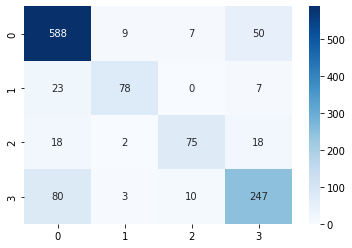

In [28]:
## TESTE COM REGRESSÃO LOGISTICA
lr = LogisticRegression()


lr.fit(X_train, y_train)                  # Emprega o conjunto de treinamento 

y_pred = lr.predict(X_test)

# print(y_pred)

#Acuracidade


print(Style.BRIGHT + Fore.RED + "MATRIZ DE CONFUSAO" + Style.RESET_ALL)
print("---------------------- \n")
print(confusion_matrix(y_test, y_pred))
print("---------------------- \n")    


print(Style.BRIGHT + Fore.RED + "ACURACIDADE" + Style.RESET_ALL)
print("---------------------- \n")
print(accuracy_score(y_test, y_pred))
print("---------------------- \n")    
# F1-SCORE

# f1 = f1_score(y_test, y_pred,pos_label='positive', average='micro')
# print(f1)

print(Fore.BLUE +  "\n \n  RELATORIO COM MAIS INFORMACOES")
print("\n \n \n ")

print(classification_report(y_test, y_pred))
print("F1 Score : ",f1_score(y_test, y_pred, average="macro"))
print("Precision Score : ",precision_score(y_test, y_pred, 
                                           average="macro"))
print("Recall Score : ",recall_score(y_test, y_pred, 
                                           average="macro"))

sb.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap='Blues', fmt='g')

### ------------------------------------------------------------------------------------------------

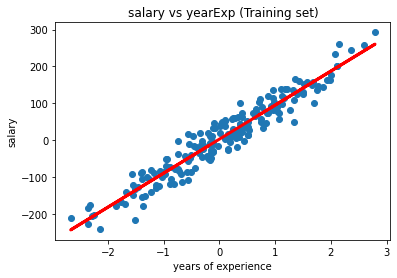

In [36]:
# from sklearn.datasets import make_regression
# x, y = make_regression(n_samples=200, n_features=1, noise=30)

# from sklearn.linear_model import LinearRegression
# modelo = LinearRegression()
# modelo.fit(x,y)
# modelo.predict(x)


# plt.scatter(x,y)
# plt.plot(x, modelo.predict(x), color='red', linewidth=3)
# plt.title('salary vs yearExp (Training set)')
# plt.xlabel('years of experience')
# plt.ylabel('salary')
# plt.show()